<h1><center>Gaussian Process Regression</center></h1>

<a href='https://juanitorduz.github.io/gaussian_process_reg/' style="color:blue;font-size:18px;"><strong>Tutorial Blog </strong></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

### Generate Data Samples

We consider the model y = f(x) + ε, where ε∼N(0,σn). Here f does not need to be a linear function of x. As a concrete example, let us consider (1-dim problem)
f(x)= sin(4πx)+sin(7πx)

In [ ]:
# Define dimension.
d = 1
# Number of samples (training set). 
n = 500

x = np.linspace(start=0, stop=1, num=n)

def f(x):
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x)
    return(f)

f_x = f(x)

fig, ax = plt.subplots()
# Plot function f. 
sns.lineplot(x=x, y=f_x, color='red', label = 'f(x)', ax=ax)
# Plot function components.
sns.lineplot(x=x, y=np.sin((4*np.pi)*x), color='orange', label='$\sin(4 \pi x)$', alpha=0.3, ax=ax)
sns.lineplot(x=x, y=np.sin((7*np.pi)*x), color='purple', label='$\sin(7 \pi x)$', alpha=0.3, ax=ax)
ax.legend(loc='upper right')
ax.set_title(r'Graph of $f(x) = \sin(4\pi x) + \sin(7\pi x)$')

In [ ]:
# Next, we generate some training sample observations:

# Error standard deviation. 
sigma_n = 0.4
# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
# Observed target variable. 
y = f_x + epsilon
# Let us see the error distribution.

fig, ax = plt.subplots()
# Plot errors. 
sns.distplot(epsilon, ax=ax)
ax.set(title='Error Distribution');

We now visualize the sample data:

In [ ]:
fig, ax = plt.subplots()
# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax);
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax);

ax.set(title='Sample Data')
ax.legend(loc='upper right')

We now consider test data points on which we want to generate predictions.

In [ ]:
n_star = 100

x_star = np.linspace(start=0, stop=1, num=n_star)

### Kernel Function
Recall that a gaussian process is completely specified by its mean and covariance functions (we usually take the mean equal to zero, although it is not necessary). A common choice is the squared exponential,

$$cov(f(x_p),f(x_q))=k_{σf,ℓ}(x_p,x_q)=σ_f \exp(−\frac{1}{2ℓ^2}||x_p−x_q||^2) $$

where $σ_f$,$ℓ$ > 0 are hyperparameters. Observe that the covariance between two samples are modeled as a function of the inputs.

Remark: “It can be shown that the squared exponential covariance function corresponds to a Bayesian linear regression model with an infinite basis functions number of basis function.” ([Gaussian Processes for Machine Learning, Ch 2.2](http://www.gaussianprocess.org/gpml/chapters/RW.pdf))

In [ ]:
def kernel_function(x, y, sigma_f=1, l=1):
    """Define squared exponential kernel function."""
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

In [ ]:
l = 0.1
sigma_f = 2

### Compute Covariance Matrices

A key observation, as illustrated in [Regularized Bayesian Regression as a Gaussian Process](https://juanitorduz.github.io/reg_bayesian_regression/), is that the specification of the covariance function implies a distribution over functions.

Let us denote by $K(X,X)∈ M_n(\mathbb{R}), K(X_∗,X)∈ M_{n_∗ × n}(\mathbb{R})$ and $K(X_∗,X_∗)∈ M_{n∗}(\mathbb{R})$ the covariance matrices applies to 
$x$  and $x_∗$.

In [ ]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(X, X) 
        - K_star = K(X_*, X)
        - K_star2 = K(X_*, X_*)
    """
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [ ]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

Visualize K

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K');

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star2, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star2');

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star');

Note how the highest values of the support of all these matrices is localized around the diagonal.

### Joint Distribution

The joint distribution of $y$  and $f_∗$  is given by

## $$ \begin{pmatrix}
	y\\
	f_*
\end{pmatrix}
 \sim \mathcal{N}(0, C) $$


where

$$ C = \begin{pmatrix}
	K(X, X) + \sigma_n^2 I & K(X, X_*)\\
	K(X_*, X) & K(X_*, X_*)
\end{pmatrix} $$

Observe that we need to add the term $σ^2_nI$ to the upper left component to account for noise (assuming additive independent identically distributed Gaussian noise). We now compute the matrix 
C
.

In [ ]:
a = np.concatenate((K + (sigma_n**2)*np.eye(n), K_star), axis=0)
b = np.concatenate((K_star.T, K_star2), axis=0)
C = np.concatenate((a, b), axis=1)
# C.shape == (n + n_star, n + n_star)


Let us verify that C is symmetric.

In [ ]:
np.all(C.T == C)

We can also see this visually:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=C, cmap='Blues', ax=ax)
ax.set(title='Components of the Covariance Matrix C')

### Prior Distribution
From the consistency requirement of gaussian processes we know that the prior distribution for $f_∗$ is $\mathcal{N}(0, K(X_*, X_*))$. Let us visualize some sample functions from this prior:

In [ ]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star2)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax)
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
ax.set(title='Samples of Prior Distribution')
ax.legend(loc='lower right');

<h2>Conditional Distribution</h2>
<p>As described in our main reference, <em>to get the posterior distribution over functions we need to restrict this joint
prior distribution to contain only those functions which agree with the observed
data points</em>, that is, we are interested in computing <span class="math inline">\(f_*|X, y, X_*\)</span>. Using the results of <a href="http://www.gaussianprocess.org/gpml/chapters/RWA.pdf">Gaussian Processes for Machine Learning, Appendinx A.2</a>, one can show that</p>
<p><span class="math display">\[
f_*|X, y, X_* 
\sim
N(\bar{f}_*, \text{cov}(f_*))
\]</span></p>
<p>where</p>
<p><span class="math display">\[
\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y \in \mathbb{R}^{n_*}
\]</span></p>
<p>and</p>
<p><span class="math display">\[
\text{cov}(f_*) = K(X_*, X_*) - K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*) \in M_{n_*}(\mathbb{R})
\]</span></p>
<p>We now calculate the parameters of the posterior distribution:</p>

In [ ]:
def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    """Compute gaussian regression parameters."""
    n = K.shape[0]
    # Mean.
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    # Covariance.
    cov_f_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (f_bar_star, cov_f_star)

In [ ]:
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set_title('Components of the Covariance Matrix cov_f_star')

Let us now sample from the posterior distribution:

In [ ]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label = 'f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

<h2>Hyperparameters</h2>
<p>We now study the effect of the hyperparameters <span class="math inline">\(\sigma_f\)</span> and <span class="math inline">\(\ell\)</span> of the kernel function defined above.</p>
<ul>
<li><p>The hyperparameter <span class="math inline">\(\sigma_f\)</span> describes the amplitude of the function.</p></li>
<li><p>The hyperparameter <span class="math inline">\(\ell\)</span> is a locality parameter, i.e. how far the points interact.</p></li>
</ul>
<p>Let us see some concrete examples:</p>
<ul>
<li><span class="math inline">\(\sigma_f = 2\)</span> and <span class="math inline">\(\ell = 1\)</span></li>
</ul>
<pre class="python"><code>

In [ ]:
l = 1
l = 1
sigma_f = 2

# Compute covariance matrices. 
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

In this case the values of the posterior covariance matrix are not that localized. This means that we expect points far away can still have some interaction, i.e. the fit becomes more global. Let us plot the resulting fit:

In [ ]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

* σf=2 and ℓ=0.001

In [ ]:
l = 0.001
sigma_f = 2

# Compute covariance matrices. 
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)
# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

In contrast, we see that for these set of hyper parameters the higher values of the posterior covariance matrix are concentrated along the diagonal. This means that we expect points far away to have no effect on each other, i.e. the fit becomes more local. Let us plot the resulting fit:

In [ ]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

<h2>GaussianProcessRegressor from Scikit-Learn</h2>
<p>Note that in the examples above he had to compute the inverse of <span class="math inline">\(K(X,X) + \sigma_n^2 I\)</span>, which can be computationally expensive for larger data sets. A better approach is to use the Cholesky decomposition of <span class="math inline">\(K(X,X) + \sigma_n^2 I\)</span> as described in <a href="http://www.gaussianprocess.org/gpml/chapters/RW2.pdf">Gaussian Processes for Machine Learning, Ch 2 Algorithm 2.1</a>. This is actually the implementation used by <a href="https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor">Scikit-Learn</a>. We now describe how to fit a GaussianProcessRegressor model using Scikit-Learn and compare it with the results obtained above. Please refer to the <a href="https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html">docomentation example</a> to get more detailed information.</p>
<div id="kernel-object" class="section level3">
<h3>Kernel Object</h3>
<p>There are my <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process">kernel functions</a> implemented in Scikit-Learn. Let us see how define the squared exponential:</p>

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))

In [ ]:
# ConstantKernel(constant_value=1,constant_value_bounds=(1e-3, 1e3)) 

<p>The tuples on each kernel component represent the lower and upper bound of the hyperparameters. The gaussian process fit automatically selects the best hyperparameters which maximize the log-marginal likelihood. The marginal likelihood is the integral of the likelihood times the prior.</p>
</div>
<div id="gaussianprocessregressor" class="section level3">
<h3>GaussianProcessRegressor</h3>
<p>Now we define de <a href="https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html"><code>GaussianProcessRegressor</code></a> object.</p>
<pre class="python"><code>

**Note:** GaussianProcessRegressor does not allow the specification of mean function which is assumed to be the zero function

**Another Resource**
[Domino Data Lab](https://blog.dominodatalab.com/fitting-gaussian-process-models-python/)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
# Define GaussianProcessRegressor object. 
# gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)
gp = GaussianProcessRegressor(alpha=0.16000000000000003, copy_X_train=True,
                         kernel=kernel * RBF(length_scale=0.1),
                         n_restarts_optimizer=10, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [ ]:
X = x.reshape(n, d)
X_star = x_star.reshape(n_star, d)
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)

### Predictions

In [ ]:
# Make the prediction on test set.
y_pred = gp.predict(X_star)
# y_pred, sigma = gp.predict(X_star, return_std=True)

# Let us plot the prediction.

fig, ax = plt.subplots()
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred', ax=ax)
ax.set(title=f'Prediction GaussianProcessRegressor, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

Next, we plot this prediction against many samples from the posterior distribution obtained above.

In [ ]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.05, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax);
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred', ax=ax);
ax.set(title=f'Prediction GaussianProcessRegressor, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right')

Credible Interval Interval
Let us compute the credible intervals:

In [ ]:
# Generate samples from posterior distribution. 
y_hat_samples = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star, size=100)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()

We now plot the confidence interval corresponding to a corridor associated with two standard deviations.

In [ ]:
fig, ax = plt.subplots()
# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax)
# Plot corridor. 
ax.fill_between(
    x=x_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green', 
    alpha = 0.3, 
    label='Credible Interval'
)
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax);
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred', ax=ax)
ax.set_title('Prediction & Credible Interval, sigma_f = {} and l = {}'.format(sigma_f, l))
ax.legend(loc='upper right')

### Summary & Final Example
In this post we have studied and experimented the fundamentals of gaussian process regression with the intention to gain some intuition about it. Let us finalize with a self-contain example where we only use the tools from Scikit-Learn.

**Construct Training Set**

In [ ]:
# Set dimension. 
d = 1
# Number of training points.
n = 1000
# Length of the training set. 
L = 2
# Generate training features.
x = np.linspace(start=0, stop=L, num=n)
X = x.reshape(n, d)
# Error standar deviation. 
sigma_n = 0.4
# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

# Generate non-linear function.
def f(x):
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x) + np.sin((3*np.pi)*x) 
    return(f)

f_x = f(x)

# Observed target variable. 
y = f_x + epsilon

**Construct Test Set**

In [ ]:
n_star = n + 300
x_star = np.linspace(start=0, stop=(L + 0.5), num=n_star)

X_star = x_star.reshape(n_star, d)

**Define Kernel and Model**

In [ ]:
# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2))
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )

**Model Fit + Predictions**

In [ ]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)
# Make the prediction on test set.
y_pred = gp.predict(X_star)
# Generate samples from posterior distribution. 
y_hat_samples = gp.sample_y(X_star, n_samples=n_star)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=1).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

**Visualize Results**

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax);
# Plot "true" linear fit.
sns.lineplot(
    x=x_star, 
    y=f(x_star), 
    color='red', 
    label='f(x)', 
    ax=ax
)
# Plot corridor. 
ax.fill_between(
    x=x_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green',
    alpha=0.3, 
    label='Credible Interval'
)
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred')
ax.set(title='Prediction & Credible Interval')
ax.legend(loc='lower left');

## Another Method

In [2]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

**Conditioning**
$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y - \mu_y), ~\Sigma_x - \Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

In [3]:
def conditional(x_new, x, y, params):
 
    B = exponential_cov(x_new, x, params)  # \Sigma_xy
    C = exponential_cov(x, x, params)  # \Sigma_y
    A = exponential_cov(x_new, x_new, params)  # \Sigma_x

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return(mu.squeeze(), sigma.squeeze())

<ErrorbarContainer object of 3 artists>

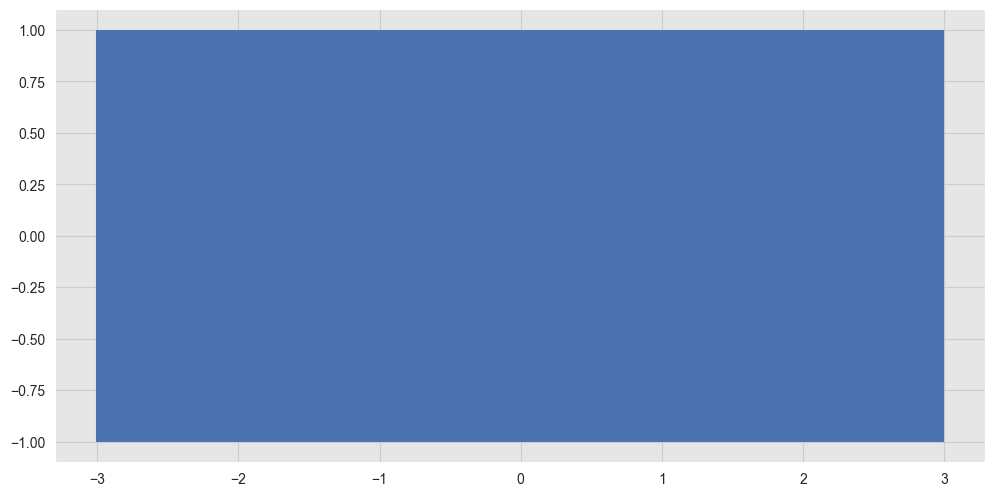

In [4]:
import matplotlib.pylab as plt
 
θ = [1, 10]  # hyperparameters
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)

In [5]:
σ_0

1.0

In [6]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[0.8825059246951147]

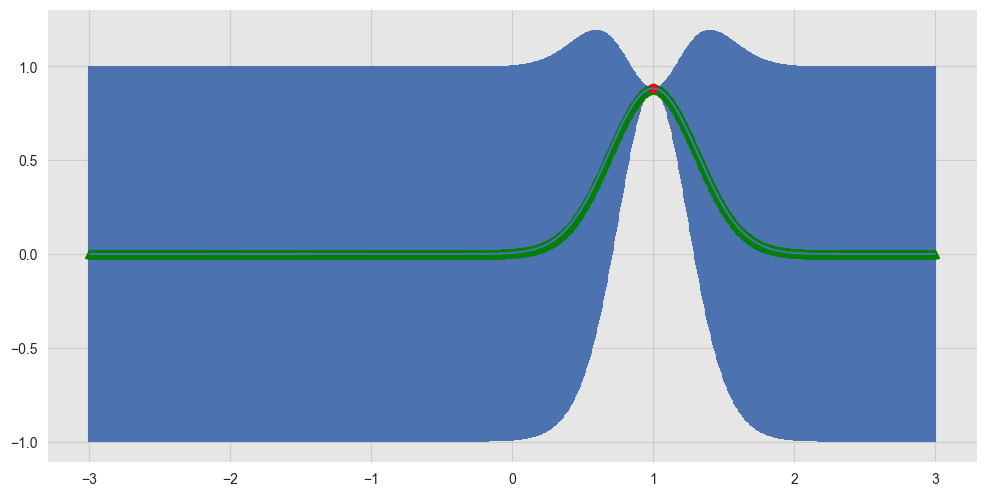

In [9]:
σ_1 = exponential_cov(x, x, θ)
 
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new
 
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x_pred, y_pred, 'g^')
plt.plot(x, y, "ro")

In [ ]:
np.where(x_pred==1)

In [ ]:
y_pred[666]

In [10]:
sigmas.shape, y_pred.shape

((1000,), (1000,))

In [ ]:
# zz = np.zeros(100)
# for i in range(100):
#     zz[i] = np.random.normal(loc=y_pred.squeeze(), scale=sigmas)
# plt.plot(x_pred, zz, 'r')

In [11]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
y2

-2.036494498073746

In [12]:
x.append(-0.7)
y.append(y2)
 
σ_2 = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

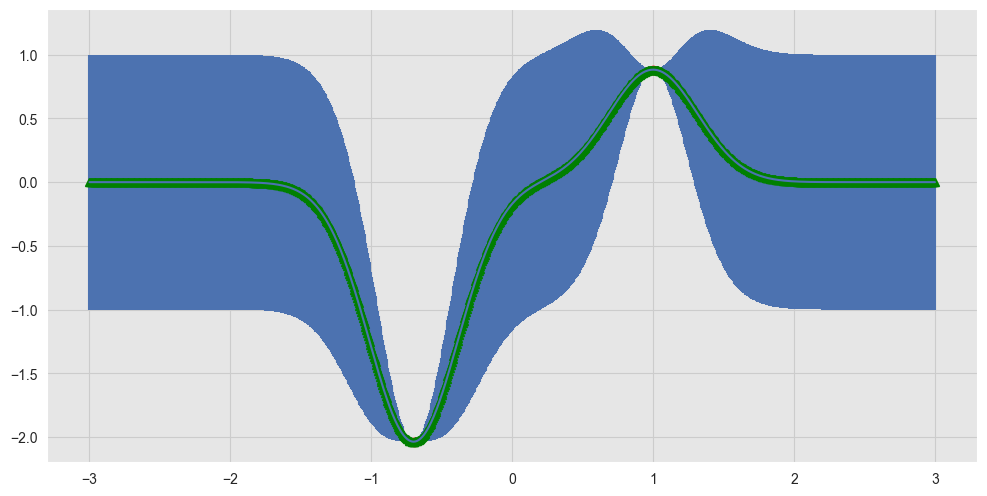

In [13]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.plot(x_pred, y_pred, 'g^')

In [14]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-0.5561484 ,  0.43085762, -0.6150391 , -0.82350262,  0.48581688])

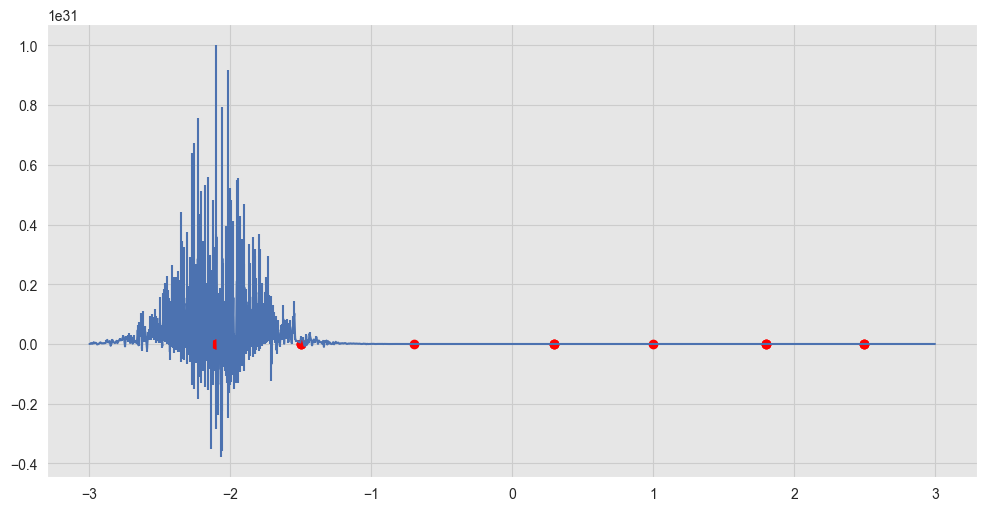

In [17]:
x += x_more
y += y_more.tolist()
 
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
 
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
# plt.plot(x_pred, y_pred, 'g^')

In [ ]:
x